In [55]:
import librosa
import numpy as np
audio_path = 'x.wav'
x , sr = librosa.load(audio_path)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(2120799,) 22050


In [56]:
time = x.shape[0]/sr
min = int(time/60)
sec = int(time-min*60)
print('{}:{}'.format(min,sec))

1:36


In [81]:
start_sec = 9
strt_stmp = int(22050*start_sec)
ln = 5
end_stmp = int(strt_stmp + 22050*ln)
X= librosa.stft(x[strt_stmp:end_stmp])

[0, 96, 0, 1000]

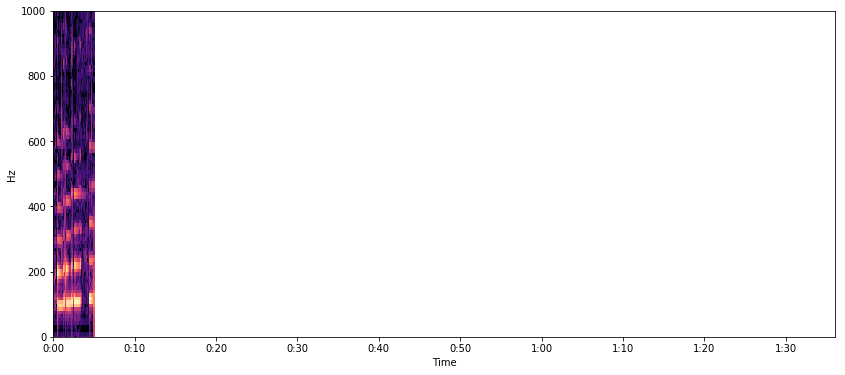

In [82]:
from matplotlib import  pyplot as plt
import librosa.display
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.axis([0,96,0,1000])

In [83]:
print(Xdb.shape)

(1025, 216)


In [84]:
max = Xdb[0].mean()
pl= 0
for pos,elem in enumerate(Xdb):
    if elem.mean() > max:
        max = elem.mean()
        pl = pos
test_mesh_coords = librosa.display.__mesh_coords('log',None,2000)
print(test_mesh_coords[11])
print(max,pl,test_mesh_coords[pl])

57.91020510255127
23.849497 10 52.39494747373686


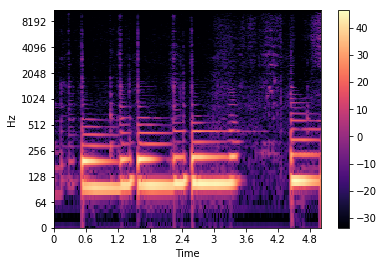

In [85]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()